# Masterclass Unsupervised analysis 
## Hands-on: Embeddings on continuous sensor data
#### Rijkswaterstaat | Datalab 

Een veelgebruikte toepassing van het embedden van data is om hoog-dimensionele ruimtes te visualiseren. In deze sessie gaan we een convolutional neural network trainen op MNIST data met handgeschreven getallen. We willen graag zien in welke mate de getallen van elkaar worden onderscheiden in een van de 'hidden layers'. Aangezien deze hidden layer 84 nodes bevat is visualiseren niet zomaar mogelijk, we gebruiken daarom PCA en TSNE om de data in deze ruimte weer te geven. 

In [ ]:
# load packages
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [ ]:
# Load data 
mnist = keras.datasets.mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


De training data bestaat uit 60000 handgeschreven zwart-wit plaatjes van cijfers.

(60000, 28, 28)


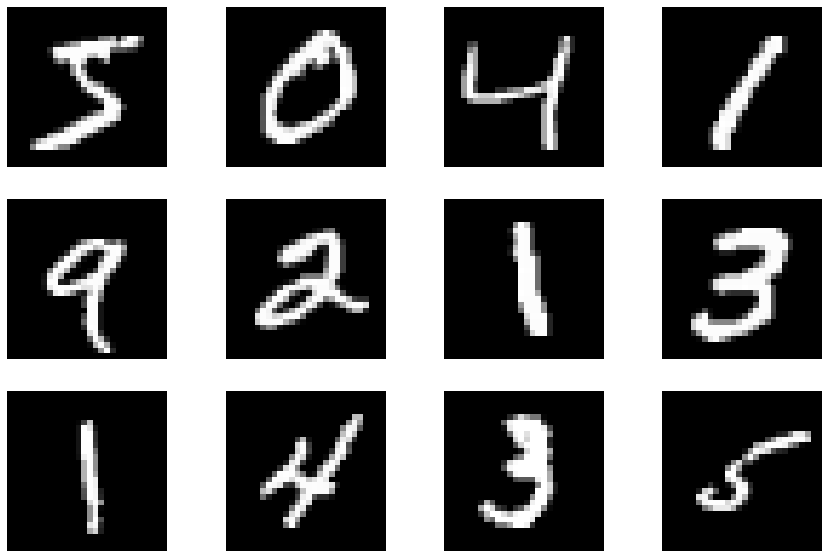

In [ ]:
print(train_images.shape)

fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(15,10))

for ax, img in zip(axs.ravel(), train_images): 
  ax.imshow(img, cmap='gray')
  ax.axis('off')


Om de data geschikt te maken voor trainen schalen we de oorspronkelijke plaatjes met pixelwaarden tussen 0 en 255 naar 0-1. Ook voegen we een 3e dimensie toe aan de plaatjes, aangezien tensorflow wil weten hoeveel channels het plaatje heeft. Een kleuren RGB plaatjes heeft 3 channels, een zwart-wit slechts 1.

In [ ]:
import numpy as np
# scale images to 0-1

train_images = train_images/255.0
test_images = test_images/255.0

# add dim for channels (only 1 channel in this data, RGB images would have 3)

train_images = np.expand_dims(train_images, -1)
test_images = np.expand_dims(test_images, -1)


We specificeren en trainen hier het model. Met keras is gemakkelijk de architectuur van het model aan te passen.

De layer die we willen bekijken geven we een naam: 'last_layer'. Dit maakt het straks gemakkelijker om de activiteit bij deze laag terug te vinden. 

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

model = Sequential()
model.add(Conv2D(6, kernel_size=3,
                 activation='relu',
                 input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(16, 3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Flatten())
model.add(Dense(120, activation='relu'))
model.add(Dense(84, activation='relu', name='last_layer'))
model.add(Dense(10, activation='softmax'))

model.summary()

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['acc'])

model.fit(x=train_images, 
          y=train_labels,
          batch_size=256,
          epochs=5,
          validation_data=(test_images, test_labels))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 6)         60        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 16)        880       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 400)               0         
_________________________________________________________________
dense (Dense)                (None, 120)               48120     
_________________________________________________________________
last_layer (Dense)           (None, 84)                1

We specificeren nu een nieuw model gebaseerd op het getrainde model, maar nu houdt het model bij 'last_layer' op. We willen kijken in hoeverre de data hier al onderscheiden wordt.

In [ ]:
# get weights at last layer

from tensorflow.keras.models import Model

last_layer = Model(inputs=model.input, outputs=model.get_layer('last_layer').output)


In [ ]:
# get activation for test data

activation = last_layer.predict(test_images)

Om deze 84 dimensionele ruimte te visualiseren transformeren we de data met TSNE. Deze zoekt naar een 2-d ruimte waarin de afstanden van de punten tot elkaar vergelijkbaar is met die in de oorspronkelijke 84d ruimte.

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE()
activation_embedded = tsne.fit_transform(activation)

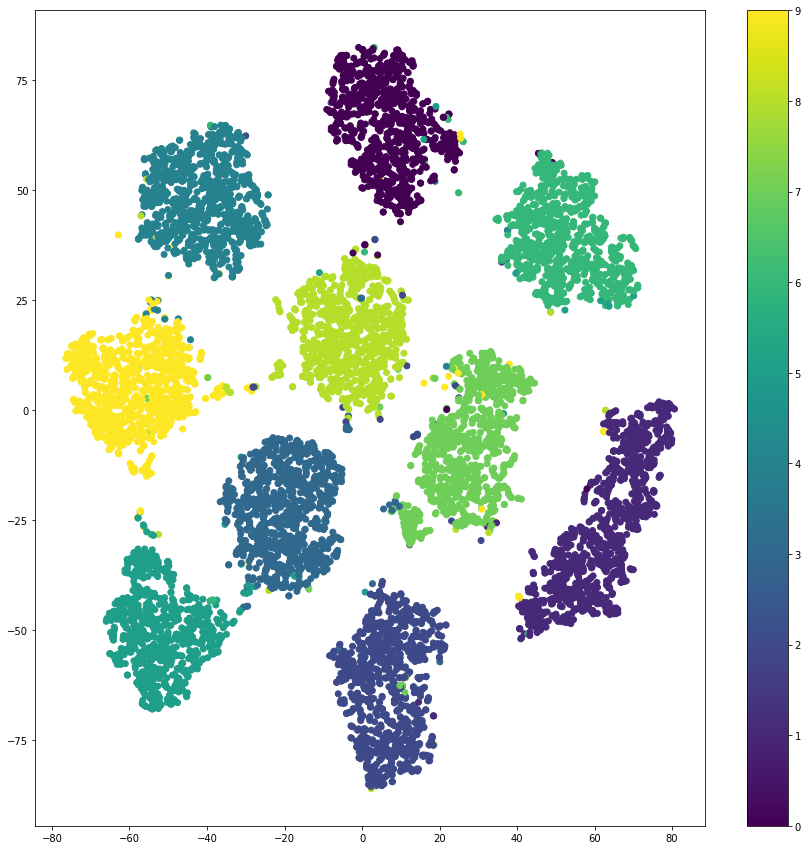

In [ ]:
plt.figure(figsize=(15,15))

plt.scatter(activation_embedded[:,0], activation_embedded[:,1], c=test_labels.astype(float))
plt.colorbar()

We doen nu hetzelfde, maar dan met PCA

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

activation_pca = pca.fit(activation).transform(activation)



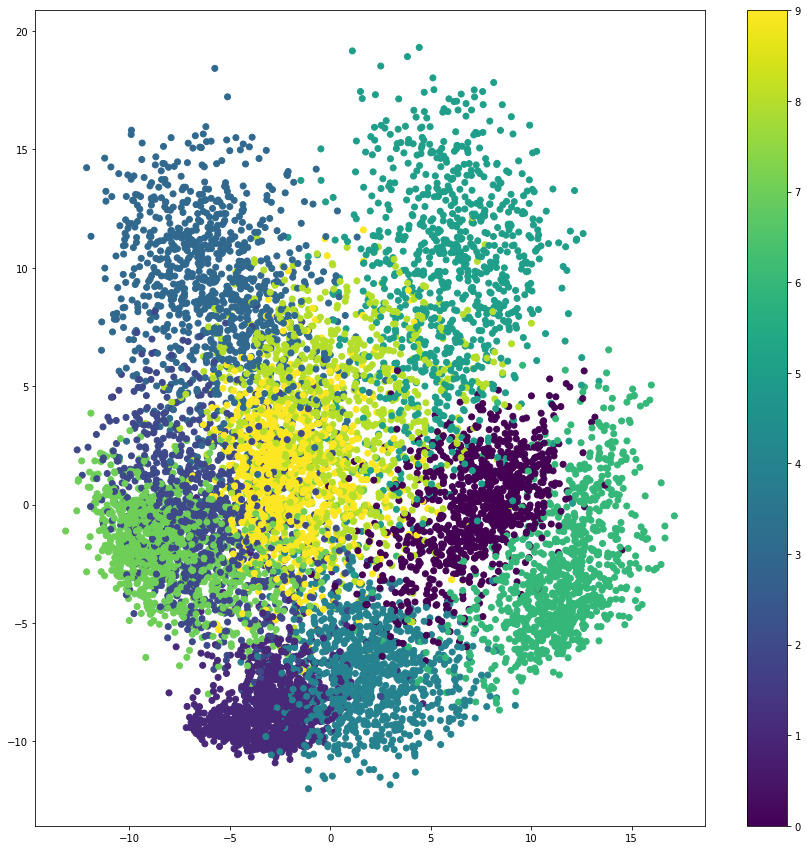

In [ ]:
plt.figure(figsize=(15,15))

plt.scatter(activation_pca[:,0], activation_pca[:,1], c=test_labels.astype(float))

plt.colorbar()